In [1]:
import numpy as np
import torch
import scanpy as sc
from data import PertDataloader, Network
import warnings
warnings.filterwarnings("ignore")

model_name = 'best_no_gnn'
args = np.load('./saved_args/'+model_name+'.npy', allow_pickle = True).item()
args['device'] = 'cuda:5'

In [2]:
if args['network_name'] == 'string':
    args['network_path'] = '/dfs/project/perturb-gnn/graphs/STRING_full_9606.csv'

if args['dataset'] == 'Norman2019':
    data_path = '/dfs/project/perturb-gnn/datasets/Norman2019/Norman2019_hvg+perts_more_de.h5ad'

adata = sc.read_h5ad(data_path)
if 'gene_symbols' not in adata.var.columns.values:
    adata.var['gene_symbols'] = adata.var['gene_name']
gene_list = [f for f in adata.var.gene_symbols.values]
# Set up message passing network
network = Network(fname=args['network_path'], gene_list=args['gene_list'],
                  percentile=args['top_edge_percent'])

# Pertrubation dataloader
pertdl = PertDataloader(adata, network.G, network.weights, args)

There are 24886 edges in the PPI.
Creating pyg object for each cell in the data...
Local copy of pyg dataset is detected. Loading...
Loading splits...
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Creating dataloaders....
Dataloaders created...


In [4]:
model = torch.load('./saved_models/' + model_name)
from inference import evaluate, compute_metrics, deeper_analysis, GI_subgroup

test_res = evaluate(pertdl.loaders['test_loader'],
                        pertdl.loaders['edge_index'],
                        pertdl.loaders['edge_attr'], model, args)

test_metrics, test_pert_res = compute_metrics(test_res)

In [5]:
out = deeper_analysis(adata, test_res)

In [6]:
# calculate mean expression for each condition
unique_conditions = adata.obs.condition.unique()
conditions2index = {}
for i in unique_conditions:
    conditions2index[i] = np.where(adata.obs.condition == i)[0]
    
condition2mean_expression = {}
for i, j in conditions2index.items():
    condition2mean_expression[i] = np.mean(adata.X[j], axis = 0)
    
pert_list = np.array(list(condition2mean_expression.keys()))
mean_expression = np.array(list(condition2mean_expression.values())).reshape(len(adata.obs.condition.unique()), adata.X.toarray().shape[1])

ctrl = mean_expression[np.where(pert_list == 'ctrl')[0]]
most_variable_genes = np.argsort(np.std(mean_expression, axis = 0))[-200:]
gene_list = adata.var['gene_name'].values

In [7]:
fold_change_all = []
for c in pert_list:
    i = np.where(pert_list == c)[0]
    pert = mean_expression[i]

    fold_change = pert/ctrl
    fold_change[np.isnan(fold_change)] = 0
    fold_change[np.isinf(fold_change)] = 0

    #fold_change[0][np.where(pert[0] < 0.5)[0]] = 0
    fold_change_all.append(fold_change[0])
    
fold_change_all = np.stack(fold_change_all)


In [8]:
combo_seen0 = pertdl.subgroup['test_subgroup']['combo_seen0']
combo_seen1= pertdl.subgroup['test_subgroup']['combo_seen1']
unseen_single = pertdl.subgroup['test_subgroup']['unseen_single']
train_perts = pertdl.set2conditions['train']

In [9]:
combo_seen0

['POU3F2+FOXL2',
 'ZBTB10+PTPN12',
 'CEBPB+PTPN12',
 'CBL+PTPN12',
 'RHOXF2BB+SET',
 'CDKN1C+CDKN1B',
 'CDKN1C+CDKN1A',
 'CDKN1B+CDKN1A',
 'C3orf72+FOXL2']

In [10]:
train_pert = train_perts[0]
pert2high_folds_up = {}
pert2low_folds_down = {}

for train_pert in train_perts:
    temp = np.where(pert_list == train_pert)[0]
    o = np.intersect1d(np.where(fold_change_all[temp][0] <0.333)[0], np.where(fold_change_all[temp][0] > 0)[0])
    if len(o) > 0:
        pert2low_folds_down[train_pert] = gene_list[o].tolist()
        
    o = np.where(fold_change_all[np.where(pert_list == train_pert)[0]][0] >3)[0]
    if len(o) > 0:
        pert2high_folds_up[train_pert] = gene_list[o].tolist()
        
        
all_high_folds = []
for i in pert2high_folds_up.values():
    all_high_folds = all_high_folds + i
    
all_high_folds_down = []
for i in pert2low_folds_down.values():
    all_high_folds_down = all_high_folds_down + i
    
all_high_folds_stats = {}

for i in pert2high_folds_up.values():
    for j in i:
        if j in all_high_folds_stats:
            all_high_folds_stats[j] += 1
        else:
            all_high_folds_stats[j] = 1


all_high_folds_down_stats = {}

for i in pert2low_folds_down.values():
    for j in i:
        if j in all_high_folds_down_stats:
            all_high_folds_down_stats[j] += 1
        else:
            all_high_folds_down_stats[j] = 1

In [13]:
all_high_folds = np.unique(all_high_folds)
all_high_folds_down = np.unique(all_high_folds_down)

In [14]:
len(all_high_folds_down)

912

In [15]:
from utils import parse_single_pert, parse_any_pert
unseen_single_gene = [parse_single_pert(i) for i in unseen_single]
genesymbol2pert = dict(zip(unseen_single_gene, unseen_single))

In [16]:
print('# of upreg perts: ' + str(len(np.unique(np.intersect1d(unseen_single_gene, all_high_folds)))))
print('# of downreg perts: ' + str(len(np.unique(np.intersect1d(unseen_single_gene, all_high_folds_down)))))
print('# of total num of perts: ' + str(len(np.unique(unseen_single_gene))))

# of upreg perts: 5
# of downreg perts: 7
# of total num of perts: 27


In [17]:
up_overlap = np.intersect1d(unseen_single_gene, all_high_folds)
down_overlap = np.intersect1d(unseen_single_gene, all_high_folds_down)
non_overlap = np.setdiff1d(unseen_single_gene, up_overlap.tolist() + down_overlap.tolist())

In [29]:
unique_train_perts_list = [parse_any_pert(i) for i in train_perts if i != 'ctrl']
unique_train_perts = []
for i in unique_train_perts_list: 
    unique_train_perts += i
unique_train_perts = np.unique(unique_train_perts)

In [30]:
from utils import parse_single_pert, parse_any_pert
unseen_combo1_gene = [parse_any_pert(i) for i in combo_seen1]
unseen_combo1_gene = [np.setdiff1d(i, unique_train_perts)[0] for i in unseen_combo1_gene]
genesymbol2pert_combo1 = dict(zip(unseen_combo1_gene, combo_seen1))

In [31]:
print('# of upreg perts: ' + str(len(np.unique(np.intersect1d(unseen_combo1_gene, all_high_folds)))))
print('# of downreg perts: ' + str(len(np.unique(np.intersect1d(unseen_combo1_gene, all_high_folds_down)))))
print('# of total num of perts: ' + str(len(np.unique(unseen_combo1_gene))))

# of upreg perts: 2
# of downreg perts: 6
# of total num of perts: 18


In [32]:
up_overlap = np.intersect1d(unseen_combo1_gene, all_high_folds)
down_overlap = np.intersect1d(unseen_combo1_gene, all_high_folds_down)
non_overlap = np.setdiff1d(unseen_combo1_gene, up_overlap.tolist() + down_overlap.tolist())

In [33]:
pert2stat = {}
for i in test_pert_res.keys():
    sep_perts = parse_any_pert(i) 
    sum_stats = []
    for j in sep_perts:
        if j in all_high_folds_stats:
            sum_stats.append(all_high_folds_stats[j])
        elif j in all_high_folds_down_stats:
            sum_stats.append(all_high_folds_down_stats[j])
        else:
            sum_stats.append(0)
    sum_stats = sum(sum_stats)/len(sum_stats)   
    pert2stat[i] = sum_stats

In [34]:
all_high_folds_stats

{'TTLL10-AS1': 35,
 'CALML6': 17,
 'TTC34': 24,
 'RP1-286D6.5': 44,
 'HES2': 18,
 'ESPN': 29,
 'CNR2': 21,
 'RP11-184I16.4': 22,
 'RP4-794H19.1': 35,
 'CLCA1': 34,
 'HFE2': 53,
 'CELF3': 21,
 'KCNN3': 26,
 'SLAMF6': 22,
 'ITLN2': 50,
 'CFHR3': 44,
 'RP11-78B10.2': 5,
 'PROX1': 39,
 'SLC35F3': 27,
 'LINC01376': 45,
 'AC020594.5': 21,
 'CDC42EP3': 18,
 'CYP1B1-AS1': 16,
 'RP11-333I13.1': 39,
 'AC007131.1': 40,
 'ATP6V1B1': 10,
 'M1AP': 32,
 'REEP1': 38,
 'KIAA1211L': 24,
 'RGPD8': 38,
 'CCDC74B': 18,
 'ERMN': 38,
 'RP11-1152H14.1': 32,
 'FSIP2': 51,
 'HECW2': 24,
 'RP11-107N15.1': 54,
 'AC079354.3': 28,
 'NYAP2': 25,
 'AC098823.3': 19,
 'RAMP1': 30,
 'RP11-266J6.2': 19,
 'RP11-24F11.2': 51,
 'ALS2CL': 24,
 'SEMA3F': 40,
 'RP11-894J14.5': 23,
 'SPATA12': 10,
 'RP11-245J9.4': 15,
 'ROBO1': 9,
 'RP11-90K6.1': 15,
 'RP11-553L6.5': 24,
 'RP11-174O3.6': 23,
 'MYLK': 40,
 'BFSP2-AS1': 61,
 'RP11-102M11.2': 15,
 'RP11-167H9.4': 9,
 'RP11-367J11.3': 22,
 'SH3TC1': 36,
 'AC195454.1': 18,
 'LINC016

Text(0, 0.5, 'testing pearson_delta_top50_de')

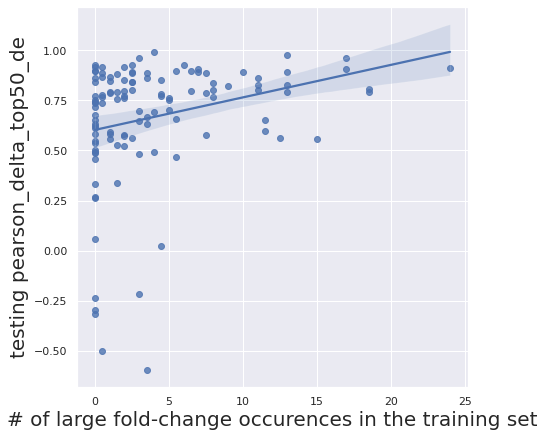

In [35]:
metric = 'pearson_delta_top50_de'
sns.set(rc={'figure.figsize':(7, 7)})

ax = sns.regplot([pert2stat[i] for i in test_pert_res.keys()],
                [out[i][metric] for i in test_pert_res.keys()])
ax.set_xlabel('# of large fold-change occurences in the training set', fontsize = 20)
ax.set_ylabel('testing ' + metric, fontsize = 20)

In [36]:
train_pert_all_inx = np.where(np.isin(pert_list, train_perts))[0]

In [37]:
np.mean(fold_change_all[train_pert_all_inx, np.where(gene_list == sep_perts[0])[0]])

1.119722

In [39]:
pert2stat = {}
for i in test_pert_res.keys():
    sep_perts = parse_any_pert(i) 
    sum_stats = []
    for j in sep_perts:
        if (i in pertdl.subgroup['test_subgroup']['combo_seen1']) and (j in unique_train_perts):
            pass
        else:
            sum_stats.append(np.quantile(fold_change_all[train_pert_all_inx, np.where(gene_list == j)[0]], 0.75))
    sum_stats = min(sum_stats)   
    pert2stat[i] = sum_stats

In [40]:
from scipy.stats import pearsonr, spearmanr

In [41]:
metric = 'pearson_delta'
stats_summary = [pert2stat[i] for i in test_pert_res.keys() if metric in out[i]]
metric_summary = [out[i][metric] for i in test_pert_res.keys() if metric in out[i]]
print(spearmanr(stats_summary, metric_summary))
print(pearsonr(stats_summary, metric_summary))

SpearmanrResult(correlation=0.01391512399484729, pvalue=0.8821418483491228)
(0.048685697494763286, 0.6037675150877887)


In [42]:
pert2status = {}

for i in ['combo_seen1', 'combo_seen2', 'combo_seen0', 'unseen_single']:
    for k in pertdl.subgroup['test_subgroup'][i]:
        pert2status[k] = i

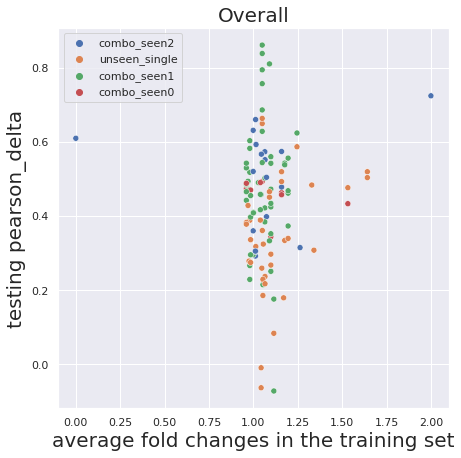

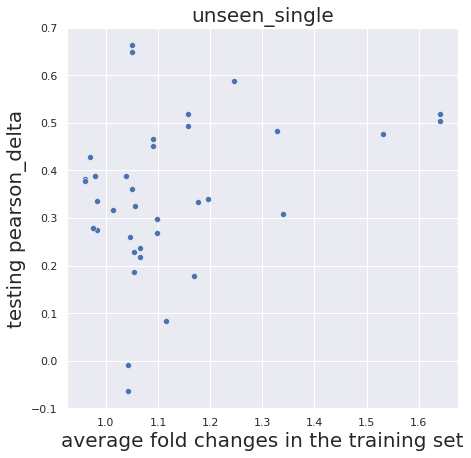

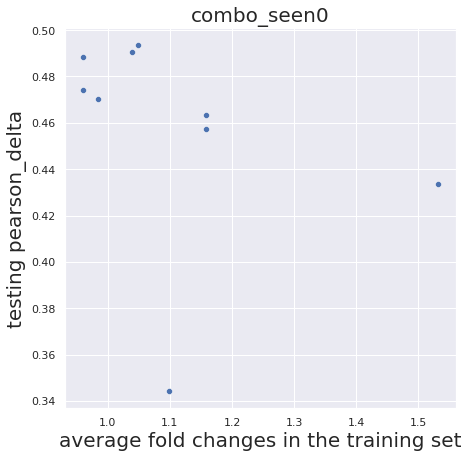

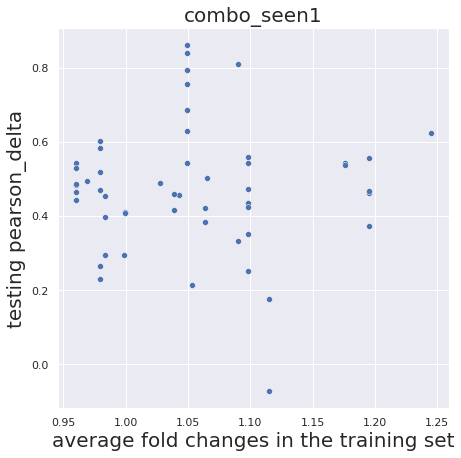

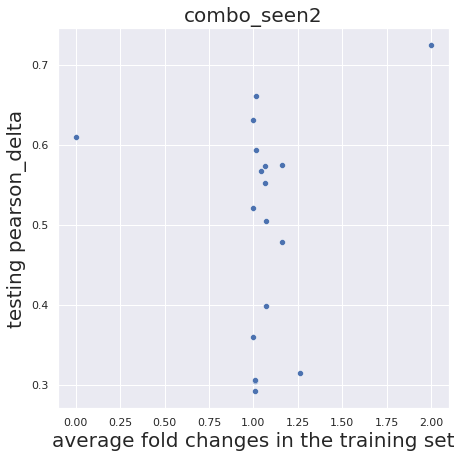

In [43]:
metric = 'pearson_delta'
sns.set(rc={'figure.figsize':(7, 7)})

plt.figure()
stats_summary = [pert2stat[i] for i in test_pert_res.keys() if metric in out[i]]
metric_summary = [out[i][metric] for i in test_pert_res.keys() if metric in out[i]]
#reduce_outlier = np.where(stats_summary < np.quantile(stats_summary, 0.85))[0]

ax = sns.scatterplot(np.array(stats_summary),
                np.array(metric_summary), hue = [pert2status[i] for i in test_pert_res.keys()])
ax.set_xlabel('average fold changes in the training set', fontsize = 20)
ax.set_ylabel('testing ' + metric, fontsize = 20)
ax.set_title('Overall', fontsize = 20)

for x in ['unseen_single', 'combo_seen0', 'combo_seen1', 'combo_seen2']:
    plt.figure()
    stats_summary = [pert2stat[i] for i in pertdl.subgroup['test_subgroup'][x] if metric in out[i]]
    metric_summary = [out[i][metric] for i in pertdl.subgroup['test_subgroup'][x] if metric in out[i]]
    #reduce_outlier = np.where(stats_summary < np.quantile(stats_summary, 0.85))[0]
    
    ax = sns.scatterplot(np.array(stats_summary),
                    np.array(metric_summary))
    ax.set_xlabel('average fold changes in the training set', fontsize = 20)
    ax.set_ylabel('testing ' + metric, fontsize = 20)
    ax.set_title(x, fontsize = 20)
    

In [45]:
delta = adata.X.toarray() - ctrl[0]
X = adata.X.toarray()
delta_mean = np.mean(delta, axis = 0)
X_mean = np.mean(X, axis = 0)
delta_std = np.std(delta, axis = 0)

In [48]:
delta.shape

(91205, 5045)

In [55]:
delta_gene_mean_all = []
delta_gene_std_all = []
delta_gene_num_all = []

for i in range(delta.shape[1]):
    gene_delta = delta[:, i]
    gene_delta_ = gene_delta[np.where(np.abs(gene_delta > 0))]
    delta_gene_num_all.append(len(gene_delta_))
    delta_gene_mean_all.append(np.mean(gene_delta_))
    delta_gene_std_all.append(np.std(gene_delta_))

In [57]:
from scipy.stats import describe

DescribeResult(nobs=5045, minmax=(1, 57848), mean=5937.826957383548, variance=176899252.79261175, skewness=2.38939975102653, kurtosis=4.41476400508896)


<AxesSubplot:ylabel='Density'>

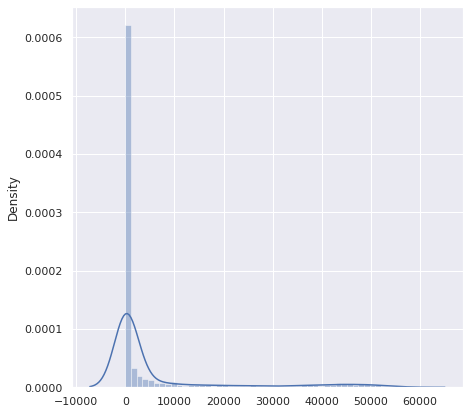

In [59]:
print(describe(delta_gene_num_all))
sns.distplot(delta_gene_num_all)

DescribeResult(nobs=5045, minmax=(0.17018929, 2.8339286), mean=0.79834354, variance=0.042382352, skewness=1.4869482303456933, kurtosis=6.68101899843499)


<AxesSubplot:ylabel='Density'>

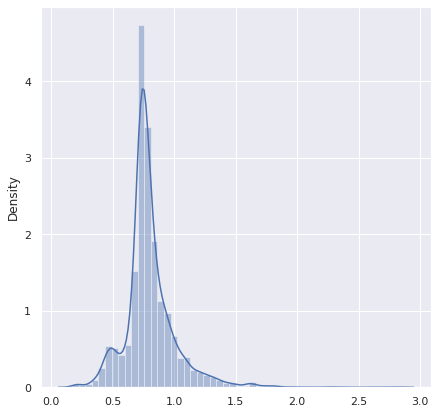

In [60]:
print(describe(delta_gene_mean_all))
sns.distplot(delta_gene_mean_all)

DescribeResult(nobs=5045, minmax=(0.0, 1.8930974), mean=0.2856708, variance=0.013711437, skewness=1.2382563679962477, kurtosis=14.626552469067224)


<AxesSubplot:ylabel='Density'>

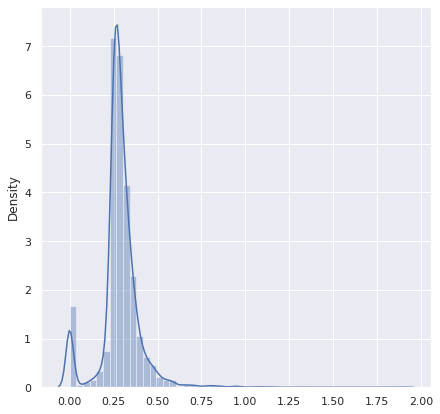

In [61]:
print(describe(delta_gene_std_all))
sns.distplot(delta_gene_std_all)

<AxesSubplot:ylabel='Density'>

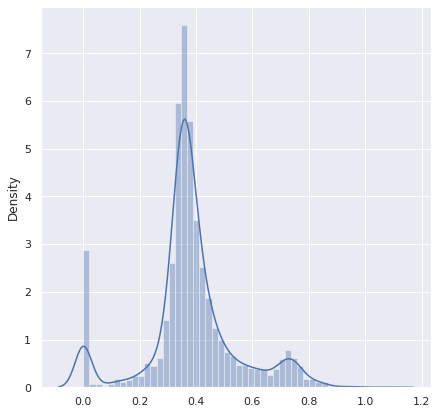

In [63]:
sns.distplot(np.array(delta_gene_std_all)/np.array(delta_gene_mean_all))

In [64]:
mean_expression_pred = {}
for pert in np.unique(test_res['pert_cat']):
    p_idx = np.where(test_res['pert_cat'] == pert)[0]
    mean_expression_pred[pert] = np.mean(test_res['pred'][p_idx], axis = 0)

In [113]:
delta_test_pred = (np.array([mean_expression_pred[i] for i in mean_expression_pred.keys()]) - ctrl)[:, most_variable_genes]

In [114]:
delta_test_true = (np.array([mean_expression[np.where(pert_list == i)[0]][0] for i in mean_expression_pred.keys()])- ctrl)[:, most_variable_genes]

In [115]:
from scipy.stats import pearsonr, spearmanr

In [116]:
delta_test_pred.shape

(116, 200)

In [117]:
gene_level_pearson = []
for i in range(delta_test_pred.shape[1]):

    pred_gene = delta_test_pred[:, i]
    true_gene = delta_test_true[:, i]
    
    gene_level_pearson.append(pearsonr(pred_gene, true_gene)[0])

Text(0, 0.5, 'Density')

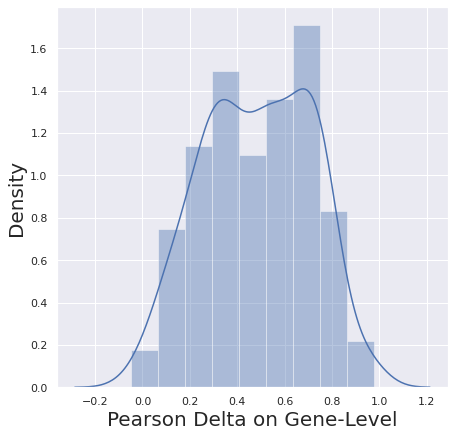

In [118]:
ax = sns.distplot(gene_level_pearson)
ax.set_xlabel('Pearson Delta on Gene-Level', fontsize = 20)
ax.set_ylabel('Density', fontsize = 20)

In [119]:
len(all_high_folds_down_stats)

912

In [125]:
train_pert = train_perts[0]
pert2high_folds_up = {}
pert2low_folds_down = {}

for train_pert in train_perts:
    temp = np.where(pert_list == train_pert)[0]
    o = np.intersect1d(np.where(fold_change_all[temp][0] <0.5)[0], np.where(fold_change_all[temp][0] > 0)[0])
    if len(o) > 0:
        pert2low_folds_down[train_pert] = gene_list[o].tolist()
        
    o = np.where(fold_change_all[np.where(pert_list == train_pert)[0]][0] >2)[0]
    if len(o) > 0:
        pert2high_folds_up[train_pert] = gene_list[o].tolist()
        
        
all_high_folds = []
for i in pert2high_folds_up.values():
    all_high_folds = all_high_folds + i
    
all_high_folds_down = []
for i in pert2low_folds_down.values():
    all_high_folds_down = all_high_folds_down + i
    
all_high_folds_stats = {}

for i in pert2high_folds_up.values():
    for j in i:
        if j in all_high_folds_stats:
            all_high_folds_stats[j] += 1
        else:
            all_high_folds_stats[j] = 1


all_high_folds_down_stats = {}

for i in pert2low_folds_down.values():
    for j in i:
        if j in all_high_folds_down_stats:
            all_high_folds_down_stats[j] += 1
        else:
            all_high_folds_down_stats[j] = 1

In [127]:
pert2stat_gene = {}
for i in gene_list:
    sum_stats = []
    if i in all_high_folds_stats:
        sum_stats.append(all_high_folds_stats[i])
    elif i in all_high_folds_down_stats:
        sum_stats.append(all_high_folds_down_stats[i])
    else:
        sum_stats.append(0)
    sum_stats = sum(sum_stats)/len(sum_stats)   
    pert2stat_gene[i] = sum_stats

<AxesSubplot:>

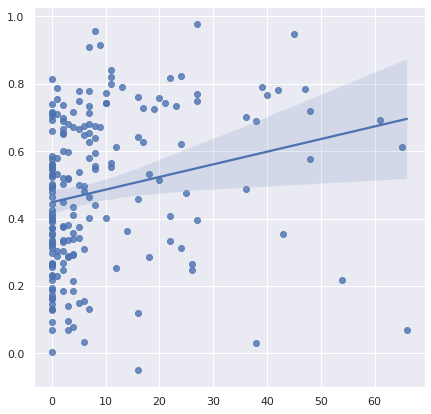

In [128]:
sns.regplot([pert2stat_gene[i] for i in gene_list[most_variable_genes]], gene_level_pearson)

In [105]:
[pert2stat_gene[i] for i in gene_list]

{'RP11-34P13.8': 0.0,
 'RP11-54O7.3': 21.0,
 'SAMD11': 24.0,
 'PERM1': 0.0,
 'HES4': 2.0,
 'ISG15': 1.0,
 'RP11-54O7.18': 0.0,
 'RNF223': 24.0,
 'LINC01342': 0.0,
 'TTLL10-AS1': 35.0,
 'TNFRSF18': 18.0,
 'TNFRSF4': 35.0,
 'TAS1R3': 21.0,
 'ANKRD65': 13.0,
 'MMP23B': 13.0,
 'RP11-345P4.7': 16.0,
 'CALML6': 17.0,
 'RP5-892K4.1': 6.0,
 'RP11-181G12.4': 0.0,
 'PLCH2': 0.0,
 'RP3-395M20.12': 10.0,
 'RP3-395M20.8': 0.0,
 'TNFRSF14': 50.0,
 'TTC34': 24.0,
 'TP73': 1.0,
 'SMIM1': 8.0,
 'RP1-286D6.5': 44.0,
 'CHD5': 26.0,
 'LINC00337': 1.0,
 'GPR153': 39.0,
 'HES2': 18.0,
 'ESPN': 29.0,
 'TAS1R1': 0.0,
 'RP11-338N10.1': 0.0,
 'TNFRSF9': 29.0,
 'RP5-1115A15.1': 0.0,
 'RP4-633I8.4': 19.0,
 'ENO1': 0.0,
 'CA6': 0.0,
 'GPR157': 14.0,
 'MIR34AHG': 9.0,
 'RP3-510D11.2': 0.0,
 'H6PD': 5.0,
 'PIK3CD-AS1': 6.0,
 'AL357140.1': 0.0,
 'PGD': 0.0,
 'C1orf127': 0.0,
 'RP4-635E18.9': 18.0,
 'MASP2': 19.0,
 'RP4-635E18.8': 15.0,
 'SRM': 3.0,
 'DRAXIN': 11.0,
 'MTHFR': 0.0,
 'PDPN': 7.0,
 'TMEM51-AS1': 3.0,
 'R

In [96]:
a = np.mean(fold_change_all, axis = 0)
a = (a - np.mean(a))/np.std(a)

<AxesSubplot:>

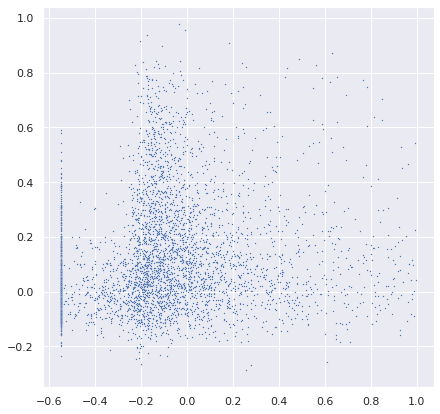

In [99]:
sns.scatterplot(a[np.where(a<1)], np.array(gene_level_pearson).reshape(-1,)[np.where(a<1)], s = 2)

In [75]:
fold_change_all[train_pert_all_inx]

array([[0.        , 1.4183697 , 0.50823873, ..., 1.0164976 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.8026875 , ..., 0.98121077, 0.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.350303  , ..., 1.0058886 , 0.        ,
        0.        ],
       [0.        , 5.538064  , 8.3577585 , ..., 0.98598784, 0.        ,
        0.        ],
       [0.        , 0.        , 0.8970307 , ..., 0.996753  , 0.        ,
        0.        ]], dtype=float32)

In [111]:
import pandas as pd
pd.read_csv('co_expression.csv').target.value_counts()

GLIPR1      11
KCNE3       11
CCR9        11
SLCO2B1     11
TMEM158     11
            ..
HOXB2        1
HOXB-AS1     1
HOXB3        1
HOXB4        1
NKX3-1       1
Name: target, Length: 4727, dtype: int64

In [112]:
pd.read_csv('co_expression.csv')

,source,target,importance
0,BDNF-AS,RP11-34P13.8,0.115654
1,CTD-2653M23.3,RP11-34P13.8,0.140285
2,ALDH3A2,RP11-34P13.8,0.215288
3,TRBC2,RP11-34P13.8,0.338329
4,RP11-34P13.8,RP11-34P13.8,1.000000
...,...,...,...
24881,SLC6A16,AC023491.2,0.147539
24882,AKAP3,AC023491.2,0.245631
24883,CYP3A4,AC023491.2,0.357960
24884,RP1-170O19.14,AC023491.2,0.414996


In [ ]:
gene_level_uncertainty